In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import random_correlation
import yfinance as yf
import datetime as dt

In [2]:
def Multi_GBM_simulator(S_0, T, mu, sigma, Cov, N, seed):
    """
    Inputs:
    
    S_0 = initial stocks price
    T = time peirod 
    mu = expected return (drift rate)
    sigma = volatility
    Cov = covariance matrix
    N = number of time steps
    seed = seed value
    
    """

    np.random.seed(seed)
    dim_var = np.size(S_0)
    t = np.linspace(0, T, N)
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim_var, N])
    S[:, 0] = S_0
    
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (T/N)
        W = np.random.normal(0, 1, dim_var)
        diffusion = np.matmul(A, W) * (np.sqrt(T/N))
        S[:, i] = S[:, i-1] * np.exp(drift + diffusion)
    
    return S, t

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


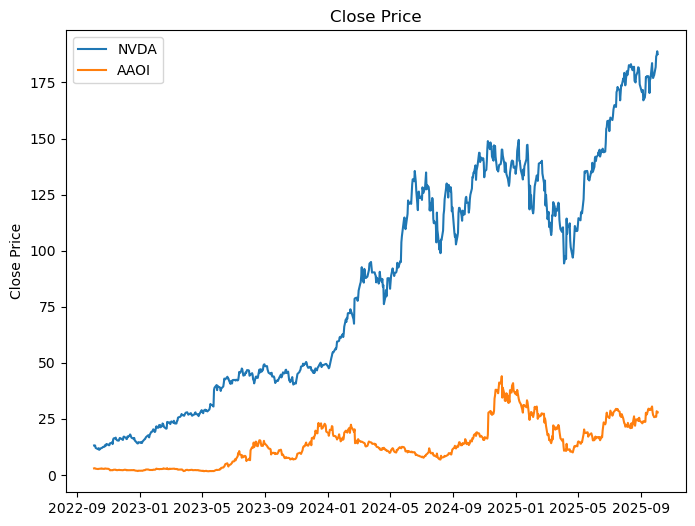

In [3]:
# Two-dimensional example

nvda = yf.download('NVDA', period = '3y', group_by = 'Ticker', auto_adjust=False)['NVDA']
aaoi = yf.download('AAOI', period = '3y', group_by = 'Ticker', auto_adjust=False)['AAOI']

plt.figure(figsize = (8,6))
plt.title('Close Price')
plt.plot(nvda['Adj Close'])
plt.plot(aaoi['Adj Close'])
plt.legend(['NVDA', 'AAOI'])
plt.ylabel('Close Price')
plt.show()

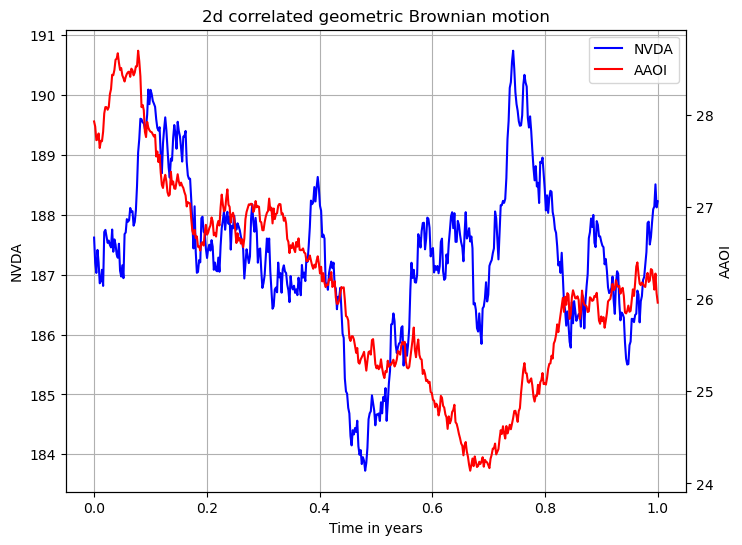

In [4]:
seed = 50  

T = 1
N = 500

S_0 = np.array([nvda['Adj Close'].iloc[-1], aaoi['Adj Close'].iloc[-1]])

nvda['log_returns'] = np.log(nvda['Adj Close']).diff()
aaoi['log_returns'] = np.log(aaoi['Adj Close']).diff()

mean_nvda = nvda['log_returns'][1:].mean()
mean_aaoi = aaoi['log_returns'][1:].mean()
mu = np.array([mean_nvda, mean_aaoi])

std_nvda = nvda['log_returns'][1:].std()
std_aaoi = aaoi['log_returns'][1:].std()
sigma = np.array([std_nvda, std_aaoi])

Cov = np.cov(nvda['log_returns'][1:], aaoi['log_returns'][1:])

stocks, time = Multi_GBM_simulator(S_0, T, mu, sigma, Cov, N, seed) 


fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(time, stocks[0,:], label="NVDA", color="blue")
ax1.set_xlabel("Time in years")
ax1.set_ylabel("NVDA")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(time, stocks[1,:], label="AAOI", color="red")
ax2.set_ylabel("AAOI")
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title('2d correlated geometric Brownian motion')
plt.show()

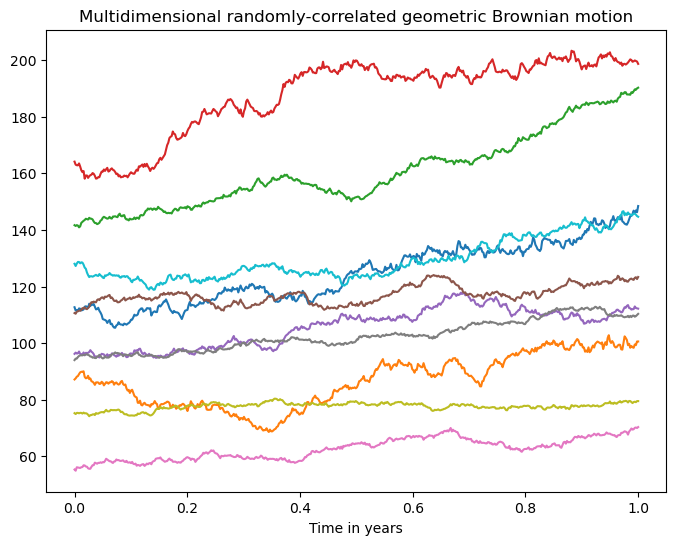

In [5]:
# Multidimensional case

seed = 50                       

dim_var = 10

T = 1
N = 500

S_0 = np.random.normal(100, 20, dim_var)
mu = np.random.uniform(0.05, 0.25, dim_var)
sigma = np.random.uniform(0.01, 0.2, dim_var)

# Random correlated geometric Bronian motion
eigen = np.random.uniform(0.1, 1, dim_var)           # generate random eigenvalues
eigen = eigen/np.sum(eigen) * dim_var                # normalize them so they sum to the dimension

# constructs a random correlation matrix that has the given eigenvalues: diagonal = 1 (self-correlation), symmetric, positive semidefinite
corr = random_correlation.rvs(eigen)    

# np.tensordot(sigma, sigma, 0) computes the outer product \sigma_i \sigma_j, then multiplying elementwise with \rho_ij
Cov = np.tensordot(sigma, sigma, 0) * corr           


stocks, time = Multi_GBM_simulator(S_0, T, mu, sigma, Cov, N, seed)

plt.figure(figsize = (8,6))
plt.title('Multidimensional randomly-correlated geometric Brownian motion')
plt.xlabel('Time in years')

for i in range(dim_var):
    plt.plot(time, stocks[i, :])

plt.show()

In [6]:
def data_yfin(stocks, start, end):
    stock_data = yf.download(stocks, start, end, auto_adjust=True)
    stock_price = stock_data['Close']
    daily_returns = stock_price.pct_change()
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()
    
    return mean_returns, cov_matrix

In [7]:
# Monte carlo simulation of a portfolio of correlated stocks

tickers_list = ['CRDO', 'ALAB', 'CLS', 'ENTG', 'AMKR', 'TSEM']

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=500)

mean_returns, cov_matrix = data_yfin(tickers_list, start_date, end_date)

# equally weighted portfolio
weights = [1/(len(tickers_list))] * len(tickers_list) # 1 by 6 matrix


[*********************100%***********************]  6 of 6 completed


In [8]:
I = 100  # number of Monte Carlo simulation paths

D = 252  # number of trading days in a year

mean_matrix = np.full(shape=(D, len(weights)), fill_value = mean_returns) # D by 6 matrix 
mean_matrix = mean_matrix.T                                               # 6 by D matrix 

portfolio = np.full(shape=(D, I), fill_value=0)                           # D by I matrix, each column is a simulation path

initial_portfolio = 10000

for i in range(0, I):
    W = np.random.normal(size=(D, len(weights)))                          # iid normal distributions, D by 6 matrix
    A = np.linalg.cholesky(cov_matrix)                                    # 6 by 6 symmetric matrix 
    day_returns = mean_matrix + np.inner(A, W)                            # compute daily returns, 6 by D matrix (NB: np.inner(A,B) := A B^T as matrix multiplication)    
    portfolio[:, i] = np.cumprod(np.inner(weights, day_returns.T) + 1) * initial_portfolio   # np.inner(weights, day_returns.T), 1 by D matrix

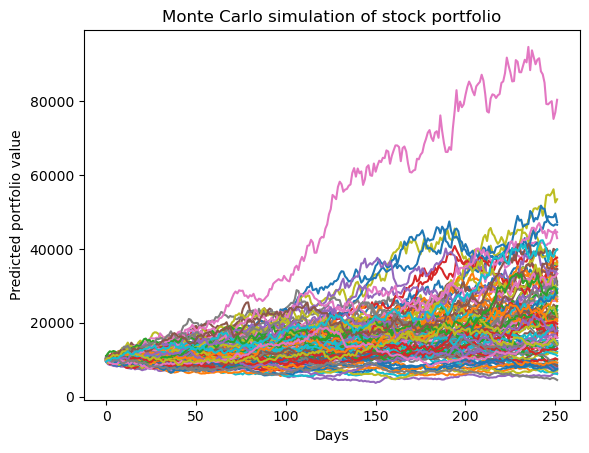

In [9]:
plt.plot(portfolio) # each column is plotted as a single line
plt.ylabel('Predicted portfolio value')
plt.xlabel('Days')
plt.title('Monte Carlo simulation of stock portfolio')
plt.show()